In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR

# Prediccion Poblacion Española

In [69]:

# Lee el archivo XLSX
datos = pd.read_excel("Poblacion_Provincias.xlsx")

poblacion = datos[datos["Provincia"] == "Total Nacional"]

columnas_seleccionadas = ['Año', 'Total', 'Natalidad', 'Mortalidad']

poblacion = poblacion[columnas_seleccionadas]

poblacion_2020 = poblacion[(poblacion['Año'] > 2010) & (poblacion['Año'] < 2021)]

poblacion_2010 = poblacion[poblacion['Año'] <= 2010]

# Puedes acceder a los datos como un DataFrame de pandas

poblacion_2020

,Año,Total,Natalidad,Mortalidad
2151,2011,46667175,471999,387911
2152,2012,46818216,454648,402950
2153,2013,46712650,425715,390419
2154,2014,46495744,427595,395830
2155,2015,46425722,420290,422568
2156,2016,46418884,410583,410611
2157,2017,46497393,393181,424523
2158,2018,46645070,372777,427721
2159,2019,46918951,360617,418703
2160,2020,47318050,341315,493776


### Prediccion con Regresion Lineal y Polinomica

Error cuadrático medio (Lineal): 1366611368209.22
Error cuadrático medio (Polinómico): 6552607205560.62


C:\Users\Jandro\AppData\Local\Temp\ipykernel_13636\3990341049.py:22: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)


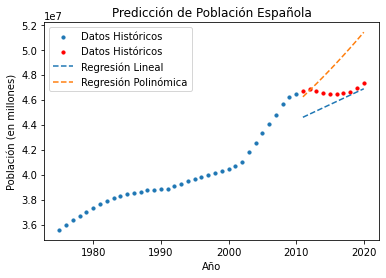

In [70]:

# Crear un conjunto de entrenamiento y prueba
X_train = np.array(poblacion_2010["Año"])
y_train = np.array(poblacion_2010["Total"])

X_test = np.array(poblacion_2020["Año"])
y_test = np.array(poblacion_2020["Total"])

# Modelo de regresión lineal
reg_lin = LinearRegression()
reg_lin.fit(X_train.reshape(-1, 1), y_train)
y_pred_lin = reg_lin.predict(X_test.reshape(-1, 1))

# Modelo de regresión polinómica
def modelo_polinomico(x, a, b, c):
    return a * x**2 + b * x + c

params_polinomico, _ = curve_fit(modelo_polinomico, X_train, y_train)
y_pred_polinomico = [modelo_polinomico(x, *params_polinomico) for x in X_test]

# Modelo de regresión exponencial
def modelo_exponencial(x, a, b):
    return a * np.exp(b * x)

params_exponencial, _ = curve_fit(modelo_exponencial, X_train, y_train)
y_pred_exponencial = [modelo_exponencial(x, *params_exponencial) for x in X_test]


# Calcular el error cuadrático medio para cada modelo
mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_polinomico = mean_squared_error(y_test, y_pred_polinomico)
#mse_exponencial = mean_squared_error(y_test, y_pred_exponencial)

# Imprimir los errores cuadráticos medios
print(f"Error cuadrático medio (Lineal): {mse_lin:.2f}")
print(f"Error cuadrático medio (Polinómico): {mse_polinomico:.2f}")
#print(f"Error cuadrático medio (Exponencial): {mse_exponencial:.2f}")

# Seleccionar el modelo con el menor error cuadrático medio
modelos = ['Lineal', 'Polinómico']
errores = [mse_lin, mse_polinomico]
mejor_modelo = modelos[errores.index(min(errores))]

# Realizar predicciones hasta 2020 con el modelo seleccionado
años_prediccion = poblacion_2020["Año"]

if mejor_modelo == 'Lineal':
    modelo = reg_lin
elif mejor_modelo == 'Polinómico':
    modelo = modelo_polinomico


#poblacion_predicha = [modelo(x) for x in años_prediccion]

# Visualizar resultados
plt.scatter(poblacion_2010["Año"], poblacion_2010["Total"], label='Datos Históricos',s=10)
plt.scatter(poblacion_2020["Año"], poblacion_2020["Total"], label='Datos Históricos',color = "red",s=10)
plt.plot(X_test, y_pred_lin, label='Regresión Lineal', linestyle='--')
plt.plot(X_test, y_pred_polinomico, label='Regresión Polinómica', linestyle='--')
plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()


### Prediccion con RandomForest, Kneighbors y SVR

Error cuadrático medio (RandomForest): 249941823783.37
Error cuadrático medio (KNeighbors): 1176405892751.48


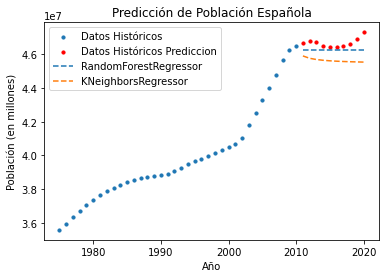

In [71]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(poblacion_2010["Año"])
y_train = np.array(poblacion_2010["Total"])

X_test = np.array(poblacion_2020["Año"])
y_test = np.array(poblacion_2020["Total"])

# Define los hiperparámetros que deseas ajustar para cada modelo
parametros_RFR = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el RandomForest
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    # Otros hiperparámetros de RandomForestRegressor
}

parametros_KnR = {
    'n_neighbors': [5, 10, 15, 20],  # Número de vecinos en KNeighborsRegressor
    'weights': ['uniform', 'distance'],  # Método de ponderación
    'algorithm': ['auto', 'ball_tree', 'kd_tree' , 'brute']
    # Otros hiperparámetros de KNeighborsRegressor
}

# Realiza la búsqueda en cuadrícula para cada modelo
grid_RFR = GridSearchCV(RandomForestRegressor(), parametros_RFR, cv=5)
grid_RFR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_RFR = grid_RFR.best_estimator_

grid_KnR = GridSearchCV(KNeighborsRegressor(), parametros_KnR, cv=5)
grid_KnR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_KnR = grid_KnR.best_estimator_


# Realiza las predicciones con los mejores modelos
y_pred_RFR = mejor_modelo_RFR.predict(X_test.reshape(-1, 1))
y_pred_KnR = mejor_modelo_KnR.predict(X_test.reshape(-1, 1))

# Calcular el error cuadrático medio para cada modelo
mse_RFR = mean_squared_error(y_test, y_pred_RFR)
mse_KnR = mean_squared_error(y_test, y_pred_KnR)

# Imprimir los errores cuadráticos medios
print(f"Error cuadrático medio (RandomForest): {mse_RFR:.2f}")
print(f"Error cuadrático medio (KNeighbors): {mse_KnR:.2f}")


# Visualizar resultados
plt.scatter(poblacion_2010["Año"], poblacion_2010["Total"], label='Datos Históricos',s=10)
plt.scatter(poblacion_2020["Año"], poblacion_2020["Total"], label='Datos Históricos Prediccion',color = "red",s=10)
plt.plot(X_test, y_pred_RFR, label='RandomForestRegressor', linestyle='--')
plt.plot(X_test, y_pred_KnR, label='KNeighborsRegressor', linestyle='--')
plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()

### Prediccion Final de la Poblacion Española

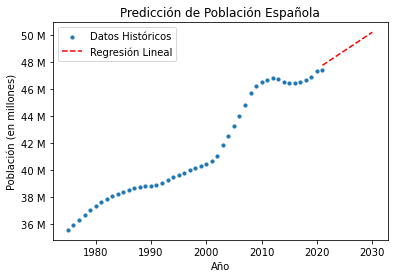

Dataset de las predicciones: 
     Año  Poblacion
0  2021   47752362
1  2022   48024095
2  2023   48295827
3  2024   48567559
4  2025   48839291
5  2026   49111023
6  2027   49382755
7  2028   49654487
8  2029   49926219
9  2030   50197951


In [83]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(poblacion["Año"])
y_train = np.array(poblacion["Total"])

X_test = np.array(list(range(2021, 2031)))

# Modelo de regresión lineal
reg_lin = LinearRegression()
reg_lin.fit(X_train.reshape(-1, 1), y_train)
y_pred_lin_pob = reg_lin.predict(X_test.reshape(-1, 1))

df_predicciones = pd.DataFrame({'Año': X_test, 'Poblacion': y_pred_lin_pob})

# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_lin_pob, label='Regresión Lineal', linestyle='--',color="red")

# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{int(x/1e6):d} M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()

# Formato personalizado para mostrar números enteros
pd.options.display.float_format = '{:.0f}'.format
print("Dataset de las predicciones: \n", df_predicciones)

# Prediccion Recursos Hidricos

In [73]:
# Lee el archivo XLSX
Agua = pd.read_excel("Agua_España.xlsx")

Agua = Agua[Agua["Comunidad"] == "Total Nacional"]

columnas_seleccionadas_2 = ['Año', 'Volumen de agua registrada y distribuida', 'Hogares', 'Poblacion']

Agua = Agua[columnas_seleccionadas_2]

Agua.rename(columns={'Volumen de agua registrada y distribuida': 'Volumen_agua'}, inplace=True)

# Calcular el porcentaje y crear la nueva columna
Agua['Porcentaje_Hogares'] = (Agua['Hogares'] / Agua['Volumen_agua']) * 100

Agua['Porcentaje_Hogares'] = Agua['Porcentaje_Hogares'].round(2)

Agua

,Año,Volumen_agua,Hogares,Poblacion,Porcentaje_Hogares
324,2000,3781680,2482085,40470182,66
325,2001,3870650,2459548,40665545,64
326,2002,3855697,2511810,41035271,65
327,2003,4019615,2602904,41827836,65
328,2004,4042399,2700928,42547454,67
329,2005,4002180,2673564,43296335,67
330,2006,3913059,2615751,44009969,67
331,2007,3778036,2543714,44784659,67
332,2008,3731399,2539891,45668938,68
333,2009,3500578,2493842,46239271,71


## Prediccion Volumen de Agua

### Prediccion con Regresion Lineal y Polinomica

C:\Users\Jandro\AppData\Local\Temp\ipykernel_13636\3680635218.py:21: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)


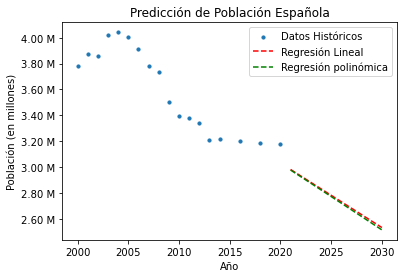

In [74]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(Agua["Año"])
y_train = np.array(Agua["Volumen_agua"])

X_test = np.array(list(range(2021, 2031)))

# Modelo de regresión lineal
reg_lin = LinearRegression()
reg_lin.fit(X_train.reshape(-1, 1), y_train)
y_pred_lin = reg_lin.predict(X_test.reshape(-1, 1))

# Modelo de regresión polinómica
def modelo_polinomico(x, a, b, c):
    return a * x**2 + b * x + c

params_polinomico, _ = curve_fit(modelo_polinomico, X_train, y_train)
y_pred_polinomico = [modelo_polinomico(x, *params_polinomico) for x in X_test]

# Modelo de regresión exponencial
def modelo_exponencial(x, a, b):
    return a * np.exp(b * x)

params_exponencial, _ = curve_fit(modelo_exponencial, X_train, y_train)
y_pred_exponencial = [modelo_exponencial(x, *params_exponencial) for x in X_test]


# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_lin, label='Regresión Lineal', linestyle='--',color="red")
plt.plot(X_test, y_pred_polinomico, label='Regresión polinómica', linestyle='--',color="green")
# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6:.2f} M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()


### Prediccion con RandomForest, Kneighbors y SVR

c:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\anaconda3\lib\site-packages\sklearn\base.py", line 705, in score
    y_pred = self.predict(X)
  File "c:\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", line 229, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "c:\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 727, in kneighbors
    raise ValueError(
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 14, n_neighbors = 15

  warnings.warn(
c:\anaconda3\li

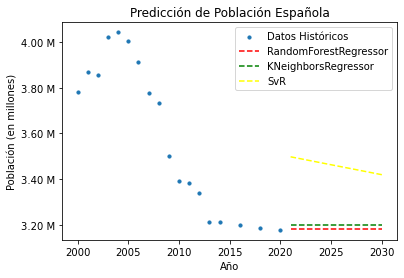

In [75]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(Agua["Año"])
y_train = np.array(Agua["Volumen_agua"])

X_test = np.array(list(range(2021, 2031)))

# Define los hiperparámetros que deseas ajustar para cada modelo
parametros_RFR = {
    'n_estimators': [10, 50, 100],  # Número de árboles en el RandomForest
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    # Otros hiperparámetros de RandomForestRegressor
}

parametros_KnR = {
    'n_neighbors': [5, 10, 15],  # Número de vecinos en KNeighborsRegressor
    'weights': ['uniform', 'distance'],  # Método de ponderación
    # Otros hiperparámetros de KNeighborsRegressor
}

parametros_SvR = {
    'C': [1, 10, 100],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    # Otros hiperparámetros de SVR
}

# Realiza la búsqueda en cuadrícula para cada modelo
grid_RFR = GridSearchCV(RandomForestRegressor(), parametros_RFR, cv=5)
grid_RFR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_RFR = grid_RFR.best_estimator_

grid_KnR = GridSearchCV(KNeighborsRegressor(), parametros_KnR, cv=5)
grid_KnR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_KnR = grid_KnR.best_estimator_

grid_SvR = GridSearchCV(SVR(), parametros_SvR, cv=5)
grid_SvR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_SvR = grid_SvR.best_estimator_

# Realiza las predicciones con los mejores modelos
y_pred_RFR = mejor_modelo_RFR.predict(X_test.reshape(-1, 1))
y_pred_KnR = mejor_modelo_KnR.predict(X_test.reshape(-1, 1))
y_pred_SvR = mejor_modelo_SvR.predict(X_test.reshape(-1, 1))


# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_RFR, label='RandomForestRegressor', linestyle='--',color="red")
plt.plot(X_test, y_pred_KnR, label='KNeighborsRegressor', linestyle='--',color="green")
plt.plot(X_test, y_pred_SvR, label='SvR', linestyle='--',color="yellow")

# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6:.2f} M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()

### Prediccion Final del Volumen de Agua

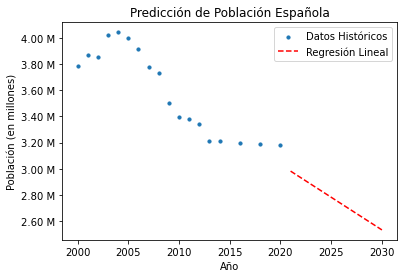

Dataset de las predicciones: 
     Año  Volumen_Agua
0  2021       2981868
1  2022       2931982
2  2023       2882096
3  2024       2832211
4  2025       2782325
5  2026       2732439
6  2027       2682554
7  2028       2632668
8  2029       2582783
9  2030       2532897


In [76]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(Agua["Año"])
y_train = np.array(Agua["Volumen_agua"])

X_test = np.array(list(range(2021, 2031)))
# Modelo de regresión lineal
reg_lin = LinearRegression()
reg_lin.fit(X_train.reshape(-1, 1), y_train)
y_pred_lin_vol = reg_lin.predict(X_test.reshape(-1, 1))

df_predicciones = pd.DataFrame({'Año': X_test, 'Volumen_Agua': y_pred_lin_vol})

# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_lin_vol, label='Regresión Lineal', linestyle='--',color="red")

# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6:.2f} M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()

# Formato personalizado para mostrar números enteros
pd.options.display.float_format = '{:.0f}'.format
print("Dataset de las predicciones: \n", df_predicciones)

## Prediccion Porcentaje de Agua suministrada a los Hogares

### Prediccion con Regresion Lineal y Polinomica

C:\Users\Jandro\AppData\Local\Temp\ipykernel_13636\2063415095.py:21: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)


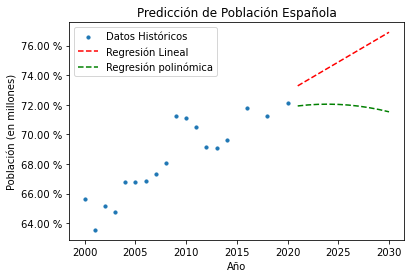

In [77]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(Agua["Año"])
y_train = np.array(Agua["Porcentaje_Hogares"])

X_test = np.array(list(range(2021, 2031)))

# Modelo de regresión lineal
reg_lin = LinearRegression()
reg_lin.fit(X_train.reshape(-1, 1), y_train)
y_pred_lin = reg_lin.predict(X_test.reshape(-1, 1))

# Modelo de regresión polinómica
def modelo_polinomico(x, a, b, c):
    return a * x**2 + b * x + c

params_polinomico, _ = curve_fit(modelo_polinomico, X_train, y_train)
y_pred_polinomico = [modelo_polinomico(x, *params_polinomico) for x in X_test]

# Modelo de regresión exponencial
def modelo_exponencial(x, a, b):
    return a * np.exp(b * x)

params_exponencial, _ = curve_fit(modelo_exponencial, X_train, y_train)
y_pred_exponencial = [modelo_exponencial(x, *params_exponencial) for x in X_test]


# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_lin, label='Regresión Lineal', linestyle='--',color="red")
plt.plot(X_test, y_pred_polinomico, label='Regresión polinómica', linestyle='--',color="green")

# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x:.2f} %')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()


### Prediccion con RandomForest, Kneighbors y SVR

c:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\anaconda3\lib\site-packages\sklearn\base.py", line 705, in score
    y_pred = self.predict(X)
  File "c:\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", line 229, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "c:\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 727, in kneighbors
    raise ValueError(
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 14, n_neighbors = 15

  warnings.warn(
c:\anaconda3\li

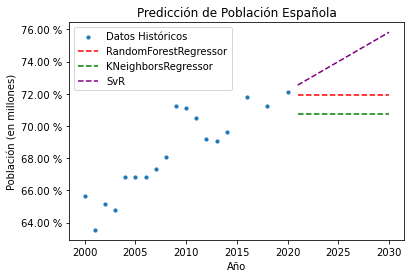

In [78]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(Agua["Año"])
y_train = np.array(Agua["Porcentaje_Hogares"])

X_test = np.array(list(range(2021, 2031)))

# Define los hiperparámetros que deseas ajustar para cada modelo
parametros_RFR = {
    'n_estimators': [10, 50, 100],  # Número de árboles en el RandomForest
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    # Otros hiperparámetros de RandomForestRegressor
}

parametros_KnR = {
    'n_neighbors': [5, 10, 15],  # Número de vecinos en KNeighborsRegressor
    'weights': ['uniform', 'distance'],  # Método de ponderación
    # Otros hiperparámetros de KNeighborsRegressor
}

parametros_SvR = {
    'C': [1, 10, 100],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    # Otros hiperparámetros de SVR
}

# Realiza la búsqueda en cuadrícula para cada modelo
grid_RFR = GridSearchCV(RandomForestRegressor(), parametros_RFR, cv=5)
grid_RFR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_RFR = grid_RFR.best_estimator_

grid_KnR = GridSearchCV(KNeighborsRegressor(), parametros_KnR, cv=5)
grid_KnR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_KnR = grid_KnR.best_estimator_

grid_SvR = GridSearchCV(SVR(), parametros_SvR, cv=5)
grid_SvR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_SvR = grid_SvR.best_estimator_

# Realiza las predicciones con los mejores modelos
y_pred_RFR = mejor_modelo_RFR.predict(X_test.reshape(-1, 1))
y_pred_KnR = mejor_modelo_KnR.predict(X_test.reshape(-1, 1))
y_pred_SvR = mejor_modelo_SvR.predict(X_test.reshape(-1, 1))

# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_RFR, label='RandomForestRegressor', linestyle='--',color="red")
plt.plot(X_test, y_pred_KnR, label='KNeighborsRegressor', linestyle='--',color="green")
plt.plot(X_test, y_pred_SvR, label='SvR', linestyle='--',color="purple")

# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x:.2f} %')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()

### Prediccion Final de los Porcentajes

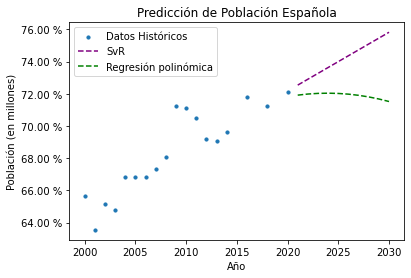

Dataset de las predicciones: 
     Año  Porcentaje_SVR  Porcentaje_Polinomica
0  2021              73                     72
1  2022              73                     72
2  2023              73                     72
3  2024              74                     72
4  2025              74                     72
5  2026              74                     72
6  2027              75                     72
7  2028              75                     72
8  2029              75                     72
9  2030              76                     72


In [79]:
# Crear un conjunto de entrenamiento y prueba
X_train = np.array(Agua["Año"])
y_train = np.array(Agua["Porcentaje_Hogares"])

X_test = np.array(list(range(2021, 2031)))

parametros_SvR = {
    'C': [1, 10, 100],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    # Otros hiperparámetros de SVR
}

grid_SvR = GridSearchCV(SVR(), parametros_SvR, cv=5)
grid_SvR.fit(X_train.reshape(-1, 1), y_train)
mejor_modelo_SvR = grid_SvR.best_estimator_

y_pred_SvR_por = mejor_modelo_SvR.predict(X_test.reshape(-1, 1))

# Modelo de regresión polinómica
def modelo_polinomico(x, a, b, c):
    return a * x**2 + b * x + c

params_polinomico, _ = curve_fit(modelo_polinomico, X_train, y_train)
y_pred_polinomico_por = [modelo_polinomico(x, *params_polinomico) for x in X_test]

df_predicciones = pd.DataFrame({'Año': X_test, 'Porcentaje_SVR': y_pred_SvR_por,'Porcentaje_Polinomica': y_pred_polinomico_por})

# Visualizar resultados
plt.scatter(X_train, y_train, label='Datos Históricos',s=10)
plt.plot(X_test, y_pred_SvR_por, label='SvR', linestyle='--',color="purple")
plt.plot(X_test, y_pred_polinomico_por, label='Regresión polinómica', linestyle='--',color="green")
# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x:.2f} %')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Población (en millones)')
plt.legend()
plt.title('Predicción de Población Española')
plt.show()

# Formato personalizado para mostrar números enteros
pd.options.display.float_format = '{:.0f}'.format
print("Dataset de las predicciones: \n", df_predicciones)

# Prediccion Final del Consumo de Agua por Habitante

In [86]:
df_final = pd.DataFrame({'Año': X_test,
                         'Poblacion': y_pred_lin_pob,
                         'Volumen_Agua': y_pred_lin_vol, 
                         'Porcentaje_SVR': y_pred_SvR_por })


df_final['Hogares'] = (df_final['Volumen_Agua'] * df_final['Porcentaje_SVR']/100)

df_final['Consumo_Habitante'] = (df_final['Hogares'] * 1000)/ df_final['Poblacion'] / 365 * 1000

df_final

,Año,Poblacion,Volumen_Agua,Porcentaje_SVR,Hogares,Consumo_Habitante
0,2021,47752362,2981868,73,2163047,124
1,2022,48024095,2931982,73,2137561,122
2,2023,48295827,2882096,73,2111712,120
3,2024,48567559,2832211,74,2085498,118
4,2025,48839291,2782325,74,2058921,115
5,2026,49111023,2732439,74,2031979,113
6,2027,49382755,2682554,75,2004672,111
7,2028,49654487,2632668,75,1977002,109
8,2029,49926219,2582783,75,1948968,107
9,2030,50197951,2532897,76,1920569,105


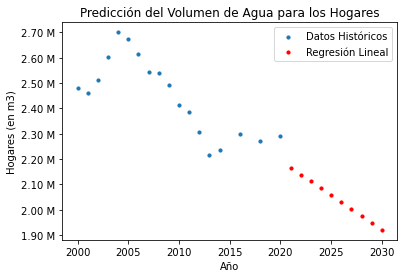

In [88]:
# Visualizar resultados
plt.scatter(Agua['Año'], Agua['Hogares'], label='Datos Históricos',s=10)
plt.scatter(df_final['Año'], df_final['Hogares'], label='Regresión Lineal', s=10,color="red")

# Personalizar el formato del eje Y para mostrar números en millones con "M"
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6:.2f} M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Año')
plt.ylabel('Hogares (en m3)')
plt.legend()
plt.title('Predicción del Volumen de Agua para los Hogares')
plt.show()